## Installation

In [ ]:
!pip install -q --upgrade transformers datasets tokenizers 
!pip install -q emoji pythainlp sklearn-pycrfsuite seqeval
!rm -r thai2transformers thai2transformers_parent 
!git clone -b dev https://github.com/vistec-AI/thai2transformers/
!mv thai2transformers thai2transformers_parent
!mv thai2transformers_parent/thai2transformers .
!pip install accelerate==0.5.1
!apt install git-lfs
!pip install sentencepiece

! git clone https://github.com/Bjarten/early-stopping-pytorch.git
import sys  
sys.path.insert(0, '/content/early-stopping-pytorch')

Cloning into 'thai2transformers'...
remote: Enumerating objects: 5838, done.
remote: Counting objects: 100% (1882/1882), done.
remote: Compressing objects: 100% (551/551), done.
remote: Total 5838 (delta 1279), reused 1811 (delta 1240), pack-reused 3956
Receiving objects: 100% (5838/5838), 17.08 MiB | 12.59 MiB/s, done.
Resolving deltas: 100% (4088/4088), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'early-stopping-pytorch' already exists and is not an empty directory.

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

## Importing the libraries



In [ ]:
from datasets import load_dataset,Dataset,DatasetDict,load_from_disk
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, Trainer, TrainingArguments,AutoTokenizer,AutoModel,AutoConfig
from transformers.modeling_outputs import SequenceClassifierOutput
from thai2transformers.preprocess import process_transformers
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from pytorchtools import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the dataset

In [ ]:
data = load_from_disk('/content/drive/MyDrive/Fake news/News-Dataset/dataset')

In [ ]:
def clean_function(examples):
   examples['text'] = process_transformers(examples['text'])
   return examples
data = data.map(clean_function)

Loading cached processed dataset at /content/drive/MyDrive/Fake news/News-Dataset/dataset/train/cache-299faecd6e4d6862.arrow
Loading cached processed dataset at /content/drive/MyDrive/Fake news/News-Dataset/dataset/test/cache-3b2a6cd0a0e09658.arrow
Loading cached processed dataset at /content/drive/MyDrive/Fake news/News-Dataset/dataset/valid/cache-43412685566bc3f9.arrow


## Fine-tuning

In [ ]:
checkpoint = "airesearch/wangchanberta-base-att-spm-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.model_max_len=416

In [ ]:
def tokenize(batch):
  return tokenizer(batch["text"], truncation=True,max_length=416)

tokenized_dataset = data.map(tokenize, batched=True)
tokenized_dataset

Loading cached processed dataset at /content/drive/MyDrive/Fake news/News-Dataset/dataset/train/cache-518fda09c4133c15.arrow
Loading cached processed dataset at /content/drive/MyDrive/Fake news/News-Dataset/dataset/test/cache-34f34877e055162d.arrow
Loading cached processed dataset at /content/drive/MyDrive/Fake news/News-Dataset/dataset/valid/cache-fe2dd79783d739d5.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 2430
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 676
    })
    valid: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 270
    })
})

In [ ]:
tokenized_dataset.set_format("torch",columns=["input_ids", "attention_mask", "labels"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
class extract_tensor(nn.Module):
    def forward(self,x):
        # Output shape (batch, features, hidden)
        tensor, _ = x
        # Reshape shape (batch, hidden)
        return tensor[:, :]

In [ ]:
def pairwise_distance_torch(embeddings, device):
    # pairwise distance matrix with precise embeddings
    precise_embeddings = embeddings.to(dtype=torch.float32)

    c1 = torch.pow(precise_embeddings, 2).sum(axis=-1)
    c2 = torch.pow(precise_embeddings.transpose(0, 1), 2).sum(axis=0)
    c3 = precise_embeddings @ precise_embeddings.transpose(0, 1)

    c1 = c1.reshape((c1.shape[0], 1))
    c2 = c2.reshape((1, c2.shape[0]))
    c12 = c1 + c2
    pairwise_distances_squared = c12 - 2.0 * c3

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = torch.max(pairwise_distances_squared, torch.tensor([0.]).to(device))
    # Get the mask where the zero distances are at.
    error_mask = pairwise_distances_squared.clone()
    error_mask[error_mask > 0.0] = 1.
    error_mask[error_mask <= 0.0] = 0.

    pairwise_distances = torch.mul(pairwise_distances_squared, error_mask)

    # Explicitly set diagonals to zero.
    mask_offdiagonals = torch.ones((pairwise_distances.shape[0], pairwise_distances.shape[1])) - torch.diag(torch.ones(pairwise_distances.shape[0]))
    pairwise_distances = torch.mul(pairwise_distances.to(device), mask_offdiagonals.to(device))
    return pairwise_distances

def TripletSemiHardLoss(y_true, y_pred, device, margin=1.0):
    labels, embeddings = y_true, y_pred

    # Reshape label tensor to [batch_size, 1].
    lshape = labels.shape
    labels = torch.reshape(labels, [lshape[0], 1])

    pdist_matrix = pairwise_distance_torch(embeddings, device)

    # Build pairwise binary adjacency matrix.
    adjacency = torch.eq(labels, labels.transpose(0, 1))
    # Invert so we can select negatives only.
    adjacency_not = adjacency.logical_not()

    batch_size = labels.shape[0]

    # Compute the mask.
    pdist_matrix_tile = pdist_matrix.repeat(batch_size, 1)
    adjacency_not_tile = adjacency_not.repeat(batch_size, 1)

    transpose_reshape = pdist_matrix.transpose(0, 1).reshape(-1, 1)
    greater = pdist_matrix_tile > transpose_reshape

    mask = adjacency_not_tile & greater

    # final mask
    mask_step = mask.to(dtype=torch.float32)
    mask_step = mask_step.sum(axis=1)
    mask_step = mask_step > 0.0
    mask_final = mask_step.reshape(batch_size, batch_size)
    mask_final = mask_final.transpose(0, 1)

    adjacency_not = adjacency_not.to(dtype=torch.float32)
    mask = mask.to(dtype=torch.float32)

    # negatives_outside: smallest D_an where D_an > D_ap.
    axis_maximums = torch.max(pdist_matrix_tile, dim=1, keepdim=True)
    masked_minimums = torch.min(torch.mul(pdist_matrix_tile - axis_maximums[0], mask), dim=1, keepdim=True)[0] + axis_maximums[0]
    negatives_outside = masked_minimums.reshape([batch_size, batch_size])
    negatives_outside = negatives_outside.transpose(0, 1)

    # negatives_inside: largest D_an.
    axis_minimums = torch.min(pdist_matrix, dim=1, keepdim=True)
    masked_maximums = torch.max(torch.mul(pdist_matrix - axis_minimums[0], adjacency_not), dim=1, keepdim=True)[0] + axis_minimums[0]
    negatives_inside = masked_maximums.repeat(1, batch_size)

    semi_hard_negatives = torch.where(mask_final, negatives_outside, negatives_inside)

    loss_mat = margin + pdist_matrix - semi_hard_negatives

    mask_positives = adjacency.to(dtype=torch.float32) - torch.diag(torch.ones(batch_size)).to(device)
    num_positives = mask_positives.sum()

    triplet_loss = (torch.max(torch.mul(loss_mat, mask_positives), torch.tensor([0.]).to(device))).sum() / num_positives
    triplet_loss = triplet_loss.to(dtype=embeddings.dtype)
    return triplet_loss


class TripletLoss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, input, target, **kwargs):
        return TripletSemiHardLoss(target, input, self.device)

In [ ]:
class CustomModel(nn.Module):
  def __init__(self,checkpoint,num_labels): 
    super(CustomModel,self).__init__() 
    self.num_labels = num_labels 

    #Load Model with given checkpoint and extract its body
    self.model = model = AutoModel.from_pretrained(checkpoint,config=AutoConfig.from_pretrained(checkpoint, output_attentions=True,output_hidden_states=True))
    self.dropout = nn.Dropout(0.1) 
    self.classifier = nn.Sequential(
      nn.Linear(768, 256),
      nn.Dropout(p=0.5),
      nn.Linear(256, 2)
    )

  def forward(self, input_ids=None, attention_mask=None,labels=None):
    #Extract outputs from the body
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

    #Add custom layers
    sequence_output = self.dropout(outputs[0]) #outputs[0]=last hidden state

    logits = self.classifier(sequence_output[:,0,:].view(-1,768)) # calculate losses
    
    loss = None
    if labels is not None:
      loss_fct = TripletLoss(device)
      a = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
      loss_fct = nn.CrossEntropyLoss()
      b = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
      loss = a*1e-3 + b
    return SequenceClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=CustomModel(checkpoint=checkpoint,num_labels=2).to(device)

Some weights of the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased were not used when initializing CamembertModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_dataset["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_dataset["valid"], batch_size=8, collate_fn=data_collator
)

In [ ]:
from transformers import AdamW,get_scheduler

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 50
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

15200


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from datasets import load_metric
metric = load_metric("f1")


In [ ]:
from tqdm.auto import tqdm

progress_bar_train = tqdm(range(num_training_steps))
progress_bar_eval = tqdm(range(num_epochs * len(eval_dataloader)))
# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = [] 

early_stopping = EarlyStopping(patience=7, verbose=True)

for epoch in range(num_epochs):
  model.train()
  size = len(train_dataloader.dataset)
  for batch, X in enumerate(train_dataloader):
      X = {k: v.to(device) for k, v in X.items()}
      outputs = model(**X)
      loss = outputs.loss
      loss.backward()

      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad()
      progress_bar_train.update(1)
      train_losses.append(loss.item())

  model.eval()
  for batch, X in enumerate(eval_dataloader):
    X = {k: v.to(device) for k, v in X.items()}
    with torch.no_grad():
        outputs = model(**X)
        loss = outputs.loss
        valid_losses.append(loss.item())

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=X["labels"])
    progress_bar_eval.update(1)

  # calculate average loss over an epoch
  train_loss = np.average(train_losses)
  valid_loss = np.average(valid_losses)
  avg_train_losses.append(train_loss)
  avg_valid_losses.append(valid_loss)
        
  epoch_len = len(str(num_epochs))
        
  loss_msg = (f'[{epoch+1:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
              f'train_loss: {train_loss:.5f} ' +
              f'valid_loss: {valid_loss:.5f}')
        
  print(loss_msg)

  # clear lists to track next epoch
  train_losses = []
  valid_losses = []

  early_stopping(valid_loss, model)
        
  if early_stopping.early_stop:
    print("Early stopping")
    break
  print(metric.compute())
  print('\n')

      

  0%|          | 0/15200 [00:00<?, ?it/s]

  0%|          | 0/1700 [00:00<?, ?it/s]

[ 1/50] train_loss: 0.73300 valid_loss: 0.71446
Validation loss decreased (inf --> 0.714458).  Saving model ...
{'f1': 0.0}


[ 2/50] train_loss: 0.74103 valid_loss: 0.70001
Validation loss decreased (0.714458 --> 0.700007).  Saving model ...
{'f1': 0.6699507389162561}


[ 3/50] train_loss: 0.73033 valid_loss: 0.70248
EarlyStopping counter: 1 out of 7
{'f1': 0.6699507389162561}


[ 4/50] train_loss: 0.71006 valid_loss: 0.69718
Validation loss decreased (0.700007 --> 0.697183).  Saving model ...
{'f1': 0.6699507389162561}


[ 5/50] train_loss: 0.71261 valid_loss: 0.69353
Validation loss decreased (0.697183 --> 0.693533).  Saving model ...
{'f1': 0.6699507389162561}


[ 6/50] train_loss: 0.71317 valid_loss: 0.69881
EarlyStopping counter: 1 out of 7
{'f1': 0.6699507389162561}


[ 7/50] train_loss: 0.71375 valid_loss: 0.69089
Validation loss decreased (0.693533 --> 0.690892).  Saving model ...
{'f1': 0.6666666666666666}


[ 8/50] train_loss: 0.70557 valid_loss: 0.69552
EarlyStopping counte

In [ ]:
model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

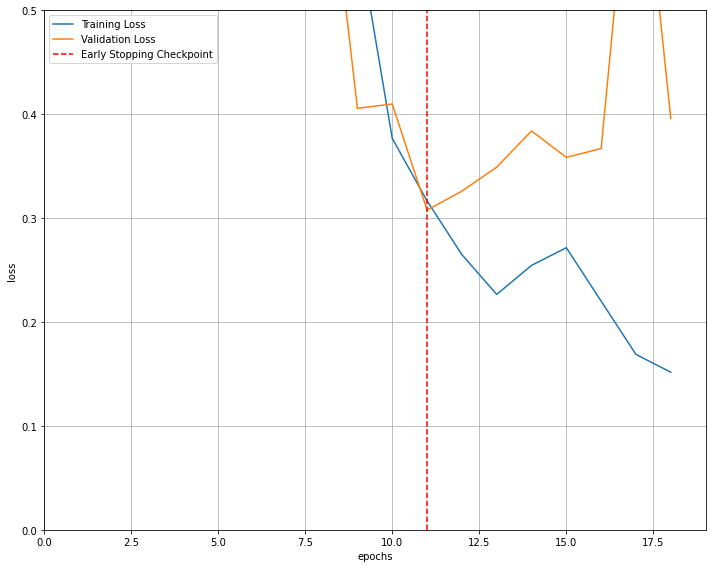

In [ ]:
# visualize the loss as the network trained
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = avg_valid_losses.index(min(avg_valid_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(avg_train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

## Test Result

In [ ]:
preds = torch.empty(0).cuda()

model.eval()

test_dataloader = DataLoader(
    tokenized_dataset["test"], batch_size=8, collate_fn=data_collator
)

for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])
    preds = torch.cat((preds, predictions), 0)

metric.compute()

{'f1': 0.8963531669865642}

In [ ]:
text = tokenized_dataset["test"]["text"]

In [ ]:
y_true = tokenized_dataset["test"]["labels"]
y_pred = preds.cpu()
print(classification_report(y_true, y_pred, target_names=['true','fake']))

              precision    recall  f1-score   support

        true       0.89      0.85      0.87       304
        fake       0.88      0.92      0.90       372

    accuracy                           0.89       676
   macro avg       0.89      0.88      0.89       676
weighted avg       0.89      0.89      0.89       676



## Wrong Prediction

In [ ]:
test_result = pd.DataFrame(zip(text, [int(x) for x in y_pred.tolist()], y_true.tolist()), columns=['text','pred','true'])
wrong_prediction = test_result[test_result['pred'] != test_result['true']]
wrong_prediction.head()

,text,pred,true
3,สูตรเครื่องดื่มล้างสารพิษในปอดใครสูบหรือดมควัน...,0,1
9,หน้ากากผ้าใช้สำหรับประชาชนทั่วไปหลักการคือกันค...,0,1
27,10ข้อดีของการออกกำลังกาย|||1.ช่วยในการนอนหลับพ...,1,0
31,กลุ่มออนไลน์จีนแนะวิธี‘สวนท่อเข้าคอ’อาเจียนออก...,0,1
33,ผู้ป่วยเกาหลีหันมาใช้ยาถ่ายพยาธิสัตว์เชื่อว่าร...,0,1


## Confusion Matrix

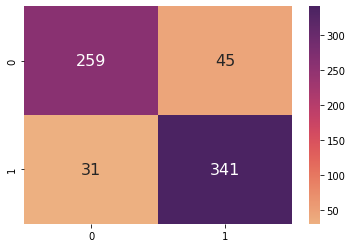

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
array = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(array, range(2), range(2))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap="flare") 
plt.show()

In [ ]:
torch.save(model, '/content/drive/MyDrive/Fake news/Model/sodabert-lstm')